<a href="https://colab.research.google.com/github/DanielDialektico/Machine-Learning/blob/main/Notebooks/Aprendizaje%20Supervisado/Regresi%C3%B3n%20Log%C3%ADstica/Regresi%C3%B3n_Log%C3%ADstica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

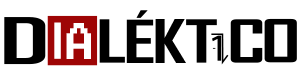

**INTRODUCCIÓN A LA REGRESIÓN LOGÍSTICA 📊**

# Introducción

En esta práctica elaboraremos un modelo de **clasificación** aplicando una **regresión logística** para procesar un conjunto de datos etiquetados obtenidos de **Spotify**. Con ello podrás experimentar las diferencias entre algoritmos de **regresión** y **clasificación**, así como aprender la forma en que se ensamblan y operan este tipo de algoritmos.

# Objetivo

Se plantea el siguiente caso: se nos ha entregado un conjunto de datos de canciones obtenido directamente de la base de datos de **Spotify**, el cual consta de 500 elementos con las siguientes **características** de cada pista: **bailabilidad**, **energía**,	**acústica**,	**duración**,	**instrumentalidad**,	**sonoridad**,	**tempo**,	**discursividad**, y **género**.
Estas métricas son creaciones propias de Spotify, y el equipo de ingeniería desea saber específicamente si las variables **bailabilidad** y **energía** son significativas al grado de poder ser un factor de diferenciación entre distintos géneros musicales.


Las tareas a realizar son las siguientes:


*  Elaborar un **modelo** de **machine learning** que pueda clasificar canciones en los géneros **black metal** y **reggaeton** de acuerdo con su grado de bailabilidad, y mostrar cuál es valor del límite de decisión.
*  Crear un modelo que, dado el valor de bailabilidad y energía de una canción, logre clasificar canciones en los dos géneros.
*  Para revisar la extensión de los resultados a otros géneros musicales, crear un modelo idéntico al segundo, pero añadiendo **salsa** a las clases.


**Nota:** la bailabilidad está definida como qué tan **bailable** es una canción respecto a algunos elementos como tempo, estabilidad del ritmo, fuerza del ritmo, entre otros. La **energía**, por otro lado, es una medida perceptiva de intensidad y actividad en la canción. Como se ha mencionado, estas son métricas creadas por Spotify. Para más contexto sobre el conjunto de datos y sus atributos, revísese el **apéndice** al final.

# Carga y exploración de datos

Comenzaremos explorando el conjunto de datos, el cual se extraerá desde un repositorio de [GitHub](https://github.com/DanielDialektico/Machine-Learning/tree/main); además, cargaremos las librerías necesarias para las tareas propuestas.

In [ ]:
# Se cargan las librerías
import pandas as pd
import sklearn
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
import warnings

# Se filtran las advertencias.
warnings.filterwarnings('ignore')

# Se define el estilo de las gráficas.
plt.style.use('seaborn-v0_8-whitegrid')

# Se carga el conjunto de datos desde un repositorio de GitHub.
dataset = pd.read_csv('https://raw.githubusercontent.com/DanielDialektico/Machine-Learning/main/Conjuntos%20de%20datos/Spotify_genres.csv')

# Se imprime el conjunto de datos.
dataset

Para una exploración más detallada, procederemos a mostrar algunas estadísticas y aspectos sobre los datos utilizando las funciones describe() e info() de [Pandas](https://pandas.pydata.org/):

In [ ]:
# Se imprimen estadísticas de cada variable.
dataset.describe()

In [ ]:
# Se imprime información sobre tipos de datos de cada variable, entre otras características.
dataset.info()

A partir de esto, podemos inferir que cada **atributo** tiene sus tipos de datos correctamente definidos, y no contamos con valores nulos. Sin embargo, aún hacen falta algunas adecuaciones.

¿Qué otros detalles notaste sobre el conjunto de datos?

# Preprocesamiento de datos

Una vez realizada la breve **exploración** de los datos, procedemos a ejecutar las etapas de **preprocesamiento**, que serán las siguientes:

*   **Limpieza de datos**: se delimitará el conjunto de datos solo a los atributos de interés (bailabilidad y energía) eliminando las columnas sobrantes; se tomarán solo los renglones etiquetados con los géneros a utilizar (black metal, reggaeton y salsa), y por último, se removerán canciones repetidas (en caso de existir).
*   **Transformación de datos**: se transformará la variable categórica "Género" a tipo numérico.


## Limpieza y transformación del conjunto de datos

Comenzaremos el preprocesamiento tomando solo las **columnas** correspondientes a las **variables** que deseamos procesar como características de entrada para el modelo:

In [ ]:
# Se filtran solo las columnas deseadas.
reduc_dataset = dataset[['Nombre','Bailabilidad','Energía','Género']]

# Se imprime el conjunto de datos.
reduc_dataset

Ahora seleccionamos solo los renglones que correspondan a **canciones** de los **géneros** que utilizaremos para alimentar al modelo:

In [ ]:
# Se seleccionan los renglones correspondientes a los géneros elegidos.
filt_dataset = reduc_dataset[reduc_dataset["Género"].isin(["black-metal", "salsa", "reggaeton"])]

# Se imprime el conjunto de datos.
filt_dataset

Ahora, en caso de existir, removemos las canciones repetidas:

In [ ]:
# Se eliminan las canciones repetidas.
prep_dataset = filt_dataset.drop_duplicates(subset=['Nombre']).reset_index(drop = True)

# Se imprime el conjunto de datos.
prep_dataset

El resultado final es una tabla con **139 renglones** y **4 columnas**, por lo que se puede inferir que se han removido 11 canciones repetidas (aprox. un 8% del total).


Hecho esto solo queda la transformación de la variable "Género" a una variable numérica **discreta**, ya que es necesario interpretar numéricamente cada categoría sobre la que se desean realizar clasificaciones.

Para esto utilizaremos la clase **labelEncoder()** de la librería Sklearn, la cual asignará valores discretos a cada categoría de forma automática:

In [ ]:
# Se codifica la variable género en cantidades discretas.
label_encoder = preprocessing.LabelEncoder()
prep_dataset['Género'] = label_encoder.fit_transform(prep_dataset['Género']) # Realiza la transformación.

# Se imprime el conjunto de datos.
prep_dataset

Con esto se realizaron las siguientes conversiones para cada salida de la variable Género:

*   Black metal = 0
*   Reggaeton = 1
*   Salsa = 2



Nótese que para el primer modelo clasificador, las **probabilidades condicionales** se van a calcular en relación al género **reggaeton**, ya que se le asignó el número 1.

Con esto concluye la etapa de **preprocesamiento**, y pasamos a confeccionar el primer **modelo**.

#Regresión logística univariable

El primer modelo que elaboraremos será el que clasifique canciones en las clases **black metal** y **reggaeton** de acuerdo con su **bailabilidad**, por lo que solo considerará una **variable** independiente (un atributo) y dos categorías (dos posibles valores de la variable dependiente). Para esto haremos uso de la clase **[LogisticRegression](https://https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)** de Sklearn.

Primero seleccionaremos solo los datos correspondientes a estos dos géneros, y realizamos la división del conjunto en los subconjuntos de **entrenamiento** y **prueba** utilizando una proporción 80-20, como hicimos en el ejercicio sobre regresión lineal.

In [ ]:
# Se seleccionan los renglones correspondientes a los géneros black metal y reggaeton
mod1_dataset = prep_dataset[prep_dataset['Género'].isin([0, 1])]

# Se generan los conjuntos de entrenamiento y prueba, definiendo cuáles son las entradas y las salidas del modelo.
inputs = mod1_dataset['Bailabilidad']
outputs = mod1_dataset['Género']
x_train, x_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.2, random_state=42)

x_train = x_train.to_numpy().reshape(-1,1) # Damos formato al conjunto de entrenamiento para utilizar la clase de Sklearn.

Ahora **entrenamos** el modelo utilizando la **regresión logística** y graficamos el modelo resultante:

In [ ]:
# Se entrena el modelo.
logisticRegr = LogisticRegression()
logisticRegr.fit(x_train, y_train.values.ravel())

#-------------Gráfica---------------
# Se crea un rango de valores para el eje x.
x_range= np.linspace(x_train.min() - 1, x_train.max() + 1, 1000)

# Se calculan los valores correspondientes al eje "y" para la curva de la función logística.
logistic_curve = logisticRegr.predict_proba(x_range.reshape(-1, 1))[:, 1]

# Se define el tamaño de la gráfica.
plt.figure(figsize=(7, 7))

# Se grafican los puntos de las dos clases del conjunto de entrenamiento.
plt.scatter(x_train[y_train.values.ravel() == 0], logisticRegr.predict_proba(x_train[y_train.values.ravel() == 0])[:, 1], color='blue', s=50)
plt.scatter(x_train[y_train.values.ravel() == 1], logisticRegr.predict_proba(x_train[y_train.values.ravel() == 1])[:, 1], color='red', s=50)

# Se grafica la curva de probabilidad predicha.
plt.plot(x_range, logistic_curve, color='black', linewidth=2)

# Se definen las leyendas de la gráfica
line = mlines.Line2D([], [], color='black', linewidth=3, label='Curva sigmoidea')
red_circle = mlines.Line2D([], [], color='blue', marker='o', linestyle='None', markersize=10, label='Clase 0')
blue_circle = mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=10, label='Clase 1')

# Se configuran las características de las leyendas.
plt.legend(handles=[line, red_circle, blue_circle], loc='upper left', prop={'family': 'DejaVu Sans', 'weight': 'bold', 'size': 11}, frameon=True, framealpha=1, facecolor='#dddddd', shadow=True)

# Se añaden títulos e información adicional.
plt.title("Función logística", fontdict={'family': 'DejaVu Sans', 'color': 'black', 'weight': 'bold', 'size': 14}, pad=15)
plt.xlabel("BAILABILIDAD", fontdict={'family': 'DejaVu Sans', 'color': 'black', 'weight': 'bold', 'size': 10}, labelpad=15)
plt.ylabel("PROBABILIDAD", fontdict={'family': 'DejaVu Sans', 'color': 'black', 'weight': 'bold', 'size': 10}, labelpad=15)
plt.suptitle("Fig. 1 Curva de probabilidad generada por el modelo resultante, donde recaen los puntos correspondientes a cada dato de entrada.", fontproperties={'family': 'DejaVu Sans', 'size': 11}, y=-0.001)

# Se limitan los ejes de la gráfica
plt.ylim(-0.1, 1.1)
plt.xlim(0, 1)

plt.show()

Recordemos que está curva está dada por el siguiente modelo:

\begin{align}
        p(y=1|x,\theta)=\frac{1}{1+e^{-(\theta_{0}+\theta_{1}x)}}\:.\tag{1.1}
    \end{align}

Donde, mediante la regresión logística, se han calculado los valores de los **parámetros** $\theta_{0}$ y $\theta_{1}$.

A continuación, imprimimos los valores obtenidos de estos coeficientes:


In [ ]:
# Se obtienen los valores de los coeficientes de regresión calculados.
theta_0 = logisticRegr.intercept_[0]
theta_1 = logisticRegr.coef_[0][0]

print(f'El valor de los parámetros de regresión de la ecuación de la recta son:\n\nθ₀ = {str(theta_0)[0:8]} \nθ₁ = {str(theta_1)[0:6]}')

Una vez ajustado el modelo, evaluamos su **precisión** (**accuracy**), la cual se da mediante la siguiente razón:

\begin{align}
        \mathrm{accuracy} = \frac{\mathrm{Predicciones\:correctas}}{\mathrm{Total\:de\:predicciones}}\:.\tag{1.2}
    \end{align}

Esta métrica no es más que la proporción de **predicciones** (**clasificaciones**) correctas realizadas sobre el conjunto de prueba.
Lo calculamos e imprimimos su valor:

In [ ]:
# Se calcula e imprime el valor de la precisión del modelo.
score = logisticRegr.score(x_test.to_numpy().reshape(-1,1), y_test.values.ravel())

print("La precisión del modelo es: " + str(score))

La razón obtenida deberá ser cercana a 1, lo cual quiere decir que el modelo acierta aproximadamente el 100% de las observaciones del conjunto de prueba, esto debido a la muy marcada separación existente entre ambos géneros musicales por su bailabilidad (o porque está *sobreajustado*, pero ese concepto lo revisaremos en otra sesión).

**Nota:** la precisión es solo una de varias medidas disponibles para la evaluación del modelo; hablaremos sobre ello en próximas exploraciones.

## Límite de decisión

Ahora exploremos brevemente el **límite de decisión**. Recordemos que este nos indica el **umbral** que determina si una observación pertenece o no a una clase determinada, y está dada por la siguiente ecuación:



\begin{align}
        b_{dec}=-\frac{\theta_0}{\theta_1}\:.\tag{1.3}
    \end{align}

donde $\theta_0$ y $\theta_1$ son los parámetros de la **función sigmoide**.

Calculamos el valor del límite de decisión:

In [ ]:
# Se realiza la división y se imprime el resultado.
decision_b  = -theta_0 / theta_1
print(f'El valor del límite de decisión es aproximadamente:\n {str(decision_b)[0:4]}')

Graficamos el límite junto a las clases sobre la curva sigmoidea:

In [ ]:
# Se define el tamaño de la gráfica.
plt.figure(figsize=(7, 7))

# Se grafican los puntos de las dos clases del conjunto de entrenamiento.
plt.scatter(x_train[y_train.values.ravel() == 0], logisticRegr.predict_proba(x_train[y_train.values.ravel() == 0])[:, 1], color='blue', s=50)
plt.scatter(x_train[y_train.values.ravel() == 1], logisticRegr.predict_proba(x_train[y_train.values.ravel() == 1])[:, 1], color='red', s=50)

# Se grafica la curva de probabilidad predicha.
plt.plot(x_range, logistic_curve, color='black', linewidth=2)

# Se grafica la línea horizontal en y=0.58 (umbral de decisión)
plt.axhline(y=decision_b, color='gray', linestyle='--')

# Se definen las leyendas de la gráfica
line = mlines.Line2D([], [], color='black', linewidth=3, label='Curva sigmoidea')
threshold_line = mlines.Line2D([], [], color='gray', linestyle='--', label='Umbral de decisión (0.58)')
red_circle = mlines.Line2D([], [], color='blue', marker='o', linestyle='None', markersize=10, label='Clase 0')
blue_circle = mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=10, label='Clase 1')

# Se configuran las características de las leyendas.
plt.legend(handles=[line, threshold_line, red_circle, blue_circle], loc='upper left', prop={'family': 'DejaVu Sans', 'weight': 'bold', 'size': 11}, frameon=True, framealpha=1, facecolor='#dddddd', shadow=True)

# Se añaden títulos e información adicional.
plt.title("Función logística y límite de decisión", fontdict={'family': 'DejaVu Sans', 'color': 'black', 'weight': 'bold', 'size': 14}, pad=15)
plt.xlabel("BAILABILIDAD", fontdict={'family': 'DejaVu Sans', 'color': 'black', 'weight': 'bold', 'size': 10}, labelpad=15)
plt.ylabel("PROBABILIDAD", fontdict={'family': 'DejaVu Sans', 'color': 'black', 'weight': 'bold', 'size': 10}, labelpad=15)
plt.suptitle("Fig. 2 Límite de decisión cortando la curva sigmoidea.", fontproperties={'family': 'DejaVu Sans', 'size': 11}, y=-0.001)

# Se limitan los ejes de la gráfica
plt.ylim(-0.1, 1.1)
plt.xlim(0, 1)

plt.show()

Con esta gráfica comprobamos que, si bien el modelo acierta en la gran mayoría de las clasificaciones, es imperfecto al momento de separar las clases, por lo que el conjunto de entrenamiento debe contener observaciones alejadas del **límite de decisión**, propiciando una alta precisión de estimación.

## Utilizando el modelo

Ahora utilizaremos el modelo para calcular la **probabilidad** y **clase** de la canción **FTBS**, la cual tiene una **bailabilidad** de **0.265**.

En el siguiente bloque se calcula la probabilidad de que esta canción pertenezca a la clase **reggaeton**, es decir, a la **clase 1**.

Primero crearemos una función auxiliar para imprimir la probabilidad y la clase calculadas por el modelo para cancione específicas:

In [ ]:
# Se crea una función para obtener la probabilidad y clase predicha por el modelo dado el nombre de una canción.

def get_predictions(song):
    cancion = mod1_dataset[mod1_dataset['Nombre'] == song]
    if not cancion.empty:
        bailabilidad = cancion['Bailabilidad'].values[0]
        prob = logisticRegr.predict_proba(np.array(bailabilidad).reshape(-1, 1))
        predict_class = logisticRegr.predict(np.array(bailabilidad).reshape(-1, 1))[0]
        if predict_class == 1:
          assigned_class = 'reggaeton'
        else:
          assigned_class = 'black metal'

        prob_class = {
            'probabilidad_clase_1': str(prob[0][1])[0:4],
            'clase_predicha': assigned_class
        }
        return prob_class
    else:
        return None

Imprimimos la probabilidad de que **FTBS** sea del género reggaeton:

In [ ]:
song = "FTBS"
resultados_ftbs = get_predictions(song)
print(f'La probabilidad de que la canción {song} pertenezca a la clase reggaeton es: {resultados_ftbs["probabilidad_clase_1"]}')

Esta predicción de probabilidad se puede visualizar sobre la curva del modelo en la **Figura 3**:

In [ ]:
prob = logisticRegr.predict_proba(np.array(0.265).reshape(-1,1))

# Se define el tamaño de la gráfica.
plt.figure(figsize=(7, 7))

# Se grafica la curva de la función logística.
plt.plot(x_range, logistic_curve, color='black', label='Curva logística', linewidth=2)
plt.plot(0.265, 0.21, 'o', markersize = 15, color="orange", label = 'Probabilidad estimada = ' + str(prob[0][1])[0:4])

# Se configuran las características de las leyendas.
plt.legend(loc='upper left', prop = {'family': 'DejaVu Sans', 'weight': 'bold', 'size': 10}, frameon = True, framealpha = 1, facecolor  = '#dddddd', shadow = True)

# Se añaden títulos e información adicional.
plt.title("Predicción de la función logística", fontdict = {'family': 'DejaVu Sans', 'color':  'black', 'weight': 'bold', 'size': 14}, pad = 14)
plt.xlabel("BAILABILIDAD", fontdict = {'family': 'DejaVu Sans', 'color':  'black', 'weight': 'bold', 'size': 10}, labelpad = 10)
plt.ylabel("PROBABILIDAD", fontdict = {'family': 'DejaVu Sans', 'color':  'black', 'weight': 'bold', 'size': 10}, labelpad = 10)
plt.suptitle("Fig. 3 Predicción realizada por el modelo visualizada sobre la curva de la función sigmoidea.", fontproperties = {'family': 'DejaVu Sans', 'size': 11}, y=-0.001)

plt.show()

Ahora que hemos calculado esta probabilidad, revisemos cuál es la **categoría** asignada por el algoritmo a la canción:

In [ ]:
print(f'La clase estimada para la canción {song} es: {resultados_ftbs["clase_predicha"]}')

### Personaliza las pruebas

¿Deseas hacer pruebas con otras canciones? Solo cambia el valor de la variable **song** por el nombre de la canción que deseas probar. Aquí tienes un ejemplo con la canción **La Jumpa**:

In [ ]:
song = "La Jumpa" # Coloca aquí, entre las comillas, el nombre de la canción que desees probar.
resultados_ftbs = get_predictions(song)
print(f'La probabilidad de que la canción {song} pertenezca a la clase reggaeton es: {resultados_ftbs["probabilidad_clase_1"]}')
print(f'La clase estimada para la canción {song} es: {resultados_ftbs["clase_predicha"]}')

# 6. Regresión logística multivariable

La siguiente tarea a realizar es crear un modelo que haga las mismas clasificaciones, pero tomando en cuenta dos variables independientes: **bailabilidad** y **energía**, por lo que se está hablando de una regresión logística multivariable.

En el siguiente fragmento se ajustará el modelo para ambas variables y se imprimirá su **precisión** de predicción.

In [ ]:
# Se seleccionan las variables y se generan los conjuntos de entrenamiento y prueba.
inputs = mod1_dataset[['Bailabilidad','Energía']]
outputs = mod1_dataset['Género']
x_train, x_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.2, random_state=42)

# Se entrena el modelo.
logisticRegr.fit(x_train, y_train)

# Se calcula e imprime el valor de la precisión del modelo.
y_pred = logisticRegr.predict(x_test)
score = logisticRegr.score(x_test, y_test)

print("La precisión del modelo es: " + str(score))

Podemos observar que la **precisión** del modelo es también del 100%; esto es porque ambas variables son linealmente separables en su totalidad, lo cual se puede constatar en la **figura 4**:

In [ ]:
# Se crea una malla de puntos en el plano.
x_min, x_max = mod1_dataset['Bailabilidad'].min() - 0.1, mod1_dataset['Bailabilidad'].max() + 0.1
y_min, y_max = mod1_dataset['Energía'].min() - 0.1, mod1_dataset['Energía'].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, 1.1, 0.001),
                     np.arange(y_min, 1.09, 0.001))

# Se obtienen las etiquetas para cada punto.
labels = mod1_dataset['Género']

# Se predicen las etiquetas de los puntos en la malla.
Z = logisticRegr.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Se crea una lista de colores para cada punto.
colors = ['blue' if label == 0 else 'red' for label in labels]

# Se define el tamaño de la gráfica.
plt.figure(figsize=(7, 7))

# Se grafican los puntos y el límite de decisión.
plt.scatter(mod1_dataset['Bailabilidad'], mod1_dataset['Energía'], c=colors)
plt.contour(xx, yy, Z, levels=[0], colors='black', linewidths=2)

# Se definen las leyendas de la gráfica.
line = mlines.Line2D([], [], color='black', linewidth=3, label='Límite de decisión')
red_circle = mlines.Line2D([], [], color='blue', marker='o', linestyle='None', markersize=10, label='Clase 0')
blue_circle = mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=10, label='Clase 1')

# Se configuran las características de las leyendas.
plt.legend(handles=[line, red_circle, blue_circle], loc='lower left', prop={'family': 'DejaVu Sans', 'weight': 'bold', 'size': 11}, frameon=True, framealpha=1, facecolor='#dddddd', shadow=True)

# Se añaden títulos e información adicional.
plt.title("Límite de decisión", fontdict = {'family': 'DejaVu Sans', 'color':  'black', 'weight': 'bold', 'size': 14}, pad = 14)
plt.xlabel("BAILABILIDAD", fontdict = {'family': 'DejaVu Sans', 'color':  'black', 'weight': 'bold', 'size': 10}, labelpad = 10)
plt.ylabel("ENERGÍA", fontdict = {'family': 'DejaVu Sans', 'color':  'black', 'weight': 'bold', 'size': 10}, labelpad = 10)
plt.suptitle("Fig. 4 Límite de decisión del modelo separando las observaciones de las dos clases existentes.", fontproperties = {'family': 'DejaVu Sans', 'size': 11}, y=-0.001)

plt.show()

La recta en la gráfica **separa** de forma consistente las dos clases de datos, lo cual demuestra que las variables **energía** y **bailabilidad** marcan una diferenciación muy precisa entre canciones de ambos géneros.

# 7. Regresión logística multivariable multiclase

Por último, se creará un modelo idéntico, con la diferencia de que se añadirá una **clase** **extra**: el género **salsa**.

Para esto volveremos a utilizar el conjunto de datos que resultó del preprocesamiento. Para la clasificación final, la librería Sklearn utiliza la función **softmax** en la definición de la pertenencia de los datos a las distintas clases. Este método será discutido en expediciones próximas.

Entrenamos el modelo con tres clases e imprimimos su precisión:

In [ ]:
# Se generan los conjuntos de entrenamiento y prueba.
inputs = prep_dataset[['Bailabilidad','Energía']]
outputs = prep_dataset['Género']
x_train, x_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.2, random_state=42)

#Se entrena el modelo.
logisticRegr.fit(x_train, y_train)

# Se calcula e imprime el valor de la precisión del modelo.
y_pred = logisticRegr.predict(x_test)
score = logisticRegr.score(x_test, y_test)

print("La precisión del modelo es: " + str(score))

Notaremos que el modelo tiene una precisión considerablemente más baja, lo cual puede ser porque las observaciones añadidas no son tan seperables como en el caso anterior.

Una forma de visualizar esto es la que se muestra en la **figura 5**:

In [ ]:
# Se crea una malla de puntos en el plano.
x_min, x_max = prep_dataset['Bailabilidad'].min() - 0.1, prep_dataset['Bailabilidad'].max() + 0.1
y_min, y_max = prep_dataset['Energía'].min() - 0.1, prep_dataset['Energía'].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 1000),
                     np.linspace(y_min, y_max, 1000))

# Se predicen las etiquetas de los puntos en la malla.
Z = logisticRegr.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Se crea una lista de colores para cada punto.
colors = ['blue' if label == 0 else 'red' if label == 1 else 'green' for label in prep_dataset['Género']]

# Se define el tamaño de la gráfica.
plt.figure(figsize=(7, 7))

# Se gracian las regiones de decisión.
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)

# Se grafican los puntos de datos.
plt.scatter(prep_dataset['Bailabilidad'], prep_dataset['Energía'], c=colors, edgecolor='k', s=50)

# Se definen las leyendas de la gráfica.
blue_circle = mlines.Line2D([], [], color='blue', marker='o', linestyle='None', markersize=10, label='Clase 0')
red_circle = mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=10, label='Clase 1')
green_circle = mlines.Line2D([], [], color='green', marker='o', linestyle='None', markersize=10, label='Clase 2')

# Se configuran las características de las leyendas.
plt.legend(handles=[blue_circle, red_circle, green_circle], loc='lower left', prop={'family': 'DejaVu Sans', 'weight': 'bold', 'size': 11}, frameon=True, framealpha=1, facecolor='#dddddd', shadow=True)

# Se añaden títulos e información adicional.
plt.title("Dispersión de los datos y límites de Decisión", fontdict={'family': 'DejaVu Sans', 'color': 'black', 'weight': 'bold', 'size': 14}, pad=14)
plt.xlabel("BAILABILIDAD", fontdict={'family': 'DejaVu Sans', 'color': 'black', 'weight': 'bold', 'size': 10}, labelpad=10)
plt.ylabel("ENERGÍA", fontdict={'family': 'DejaVu Sans', 'color': 'black', 'weight': 'bold', 'size': 10}, labelpad=10)
plt.suptitle("Fig. 5 Dispersión de los datos etiquetados por clases, separados por los límites de decisión calculados.", fontproperties={'family': 'DejaVu Sans', 'size': 11}, y=-0.001)

# Se limitan los ejes de la gráfica
plt.ylim(y_min, y_max)
plt.xlim(x_min, x_max)

plt.show()

Sin entrar en detalles matemáticos, para un modelo multiclase se definen **regiones de decisión**, las cuales determinan la pertenencia de cada dato a una clase específica. En la gráfica se observan límites de decisión distinguibles pero no perfectos; específicamente, los puntos correspondientes a las clases 1 y 2 se ven relativamente mezclados. Esto se puede explicar por **similitudes** en las canciones respecto a las características seleccionadas.

Sin embargo, los resultados de los tres modelos apuntan a que las métricas involucradas pueden ser marcadores efectivos de **diferenciación** entre canciones de diferentes **géneros musicales**.

Para crear modelos multicaclase con mayor precisión se pueden sumar otras variables, o incluso utilizar modelos de clasificación diferentes.

Ahora puedes experimentar con distintas combinaciones de **clases** y **métricas** para el entrenamiento de modelos clasificadores con regresión logística.

# 8. Ejercicio (opcional)

Por último, tienes la oportunidad de elegir las **clases** y **métricas** que gustes para el entrenamiento del modelo. Recuerda que puedes elegir entre las siguientes características (sin contar Nombre y Género):

In [ ]:
# Se imprimen las características del conjunto de datos.
dataset.columns.tolist()

Y las siguientes clases:

In [ ]:
# Se imprimen los géneros disponibles.
dataset['Género'].unique().tolist()

Modifica el siguiente fragmento con tus elecciones (no olvides colocar el texto entre comillas simples o dobles):

In [ ]:
# Se carga el conjunt de datos.
dataset = pd.read_csv('https://raw.githubusercontent.com/DanielDialektico/Machine-Learning/main/Conjuntos%20de%20datos/Spotify_genres.csv')

# Se eligen dos atributos.
attribute_1 = ''# Escribe tu elección.
attribute_2 = ''# Escribe tu elección.

# Se eligen dos géneros.
genre_1 = ''# Escribe tu elección.
genre_2 = ''# Escribe tu elección.

# Se preprocesa el conjunto de datos.
dataset = dataset.loc[:, ['Nombre', attribute_1, attribute_2, 'Género']]
dataset = dataset.loc[dataset.iloc[:, -1].isin([genre_1, genre_2])]
dataset = dataset.drop_duplicates(subset=['Nombre']).reset_index(drop = True)
dataset['Género'] = label_encoder.fit_transform(dataset['Género'])

dataset

Ahora entrena tu modelo ejecutando el siguiente fragmento sin hacer modificaciones al código, y observa el valor de su precisión:

In [ ]:
# Se generan los conjuntos de entrenamiento y prueba.
inputs = dataset[[attribute_1, attribute_2]]
outputs = dataset['Género']
x_train, x_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.2, random_state=42)

#Se entrena el modelo.
logisticRegr.fit(x_train, y_train)

#Se calcula e imprime la precisión del modelo.
y_pred = logisticRegr.predict(x_test)
score = logisticRegr.score(x_test, y_test)

print("La precisión del modelo es: " + str(score))

Por último, indaga en cómo luce la separación de clases ejecutando la siguiente celda:

In [ ]:
# Se crea una malla de puntos en el plano.
x_min, x_max = dataset[attribute_1].min() - 0.1, dataset[attribute_1].max() + 0.1
y_min, y_max = dataset[attribute_2].min() - 0.1, dataset[attribute_2].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 2000), np.linspace(y_min, y_max, 2000))

# Se obtienen las etiquetas para cada punto.
labels = dataset['Género']

# Se predicen las etiquetas de los puntos en la malla.
Z = logisticRegr.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Se crea una lista de colores para cada punto.
colors = ['blue' if label == 0 else 'red' for label in labels]

# Se define el tamaño de la gráfica.
plt.figure(figsize=(7, 7))

# Se grafican los puntos y el límite de decisión.
plt.scatter(dataset[attribute_1], dataset[attribute_2], c=colors)
plt.contour(xx, yy, Z, levels=[0], colors='black', linewidths=2)

# Se definen las leyendas de la gráfica.
line1 = mlines.Line2D([], [], color='black', linewidth=3, label='Límite de decisión')
red_circle = mlines.Line2D([], [], color='blue', marker='o', linestyle='None', markersize=7, label='Clase 0')
blue_circle = mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=7, label='Clase 1')

# Se configuran las características de las leyendas.
plt.legend(handles=[line1, red_circle, blue_circle], loc='center left', prop={'family': 'DejaVu Sans', 'weight': 'bold', 'size': 8}, frameon=True, framealpha=1, facecolor='#dddddd', shadow=True)

# Se añaden títulos e información adicional.
plt.title("Límite de decisión", fontdict = {'family': 'DejaVu Sans', 'color':  'black', 'weight': 'bold', 'size': 14}, pad = 14)
plt.xlabel(attribute_1, fontdict = {'family': 'DejaVu Sans', 'color':  'black', 'weight': 'bold', 'size': 10}, labelpad = 10)
plt.ylabel(attribute_2, fontdict = {'family': 'DejaVu Sans', 'color':  'black', 'weight': 'bold', 'size': 10}, labelpad = 10)

plt.show()

¿Cuáles han sido tus resultados?, ¿encontraste alguna combinación linealmente separable? Compártenos tus resultados en los comentarios de la lección.

Con este ejercicio concluye esta práctica de regresión logística, recomiendo que tomes tu tiempo haciendo tus propios experimentos en el último apartado.

▶ [Regresar a la lección](https://dialektico.com/regresion-logistica-fundamentos/) 🧙

# 9. Apéndice

## Conjunto de datos

Este conjunto de datos fue extraído por **Dialéktico** utilizando la **API** de **Spotify**, consta de 500 canciones y 9 atributos:

**Género**: género musical al que pertenece la canción.

**Nombre**: nombre de la canción.

**Acústica**: medida de confianza de 0,0 a 1.0 de si la pista es acústica. 1.0 representa una alta confianza en que la pista es acústica.

**Bailabilidad**: describe qué tan adecuada es una pista para bailar en función de una combinación de elementos musicales que incluyen tempo, estabilidad del ritmo, fuerza del ritmo y regularidad general. Un valor de 0,0 es menos bailable y 1.0 es más bailable.

**Duración (ms)**: duración de la pista en milisegundos.

**Energía**: medida de 0.0 a 1.0 que representa un grado perceptivo de intensidad y actividad. Por lo general, las pistas enérgicas se sienten rápidas, fuertes y ruidosas. Por ejemplo, el death metal tiene mucha energía, mientras que un preludio de Bach tiene una puntuación baja en la escala. Las características perceptivas que contribuyen a este atributo incluyen el rango dinámico, el volumen percibido, el timbre, la tasa de inicio y la entropía general.

**Instrumentalidad**: predice si una pista no contiene voces. Los sonidos "Ooh" y "aah" se tratan como instrumentales en este contexto. Las pistas de rap o de palabras habladas son claramente "vocales". Cuanto más cerca esté el valor de instrumentalidad de 1.0, mayor será la probabilidad de que la pista no contenga contenido vocal. Los valores superiores a 0.5 pretenden representar pistas instrumentales, pero la confianza es mayor a medida que el valor se acerca a 1.0.

**Sonoridad**: volumen general de una pista en decibelios (dB). Los valores de sonoridad se promedian en toda la pista y son útiles para comparar la sonoridad relativa de las pistas. El volumen es la cualidad de un sonido que es el principal correlato psicológico de la fuerza física (amplitud). Los valores suelen oscilar entre -60 y 0 db.

**Tempo**: el tempo general estimado de una pista en pulsaciones por minuto (BPM). En terminología musical, el tempo es la velocidad o ritmo de una pieza dada y se deriva directamente de la duración promedio del tiempo.

**Discursividad**: detecta la presencia de palabras habladas en una pista. Cuanto más se parece exclusivamente al habla la grabación (por ejemplo, programa de entrevistas, audiolibro, poesía), más cerca de 1.0 es el valor del atributo. Los valores superiores a 0.66 describen pistas que probablemente estén formadas en su totalidad por palabras habladas. Los valores entre 0.33 y 0.66 describen pistas que pueden contener tanto música como voz, ya sea en secciones o en capas, incluidos casos como la música rap. Los valores por debajo de 0.33 probablemente representen música y otras pistas que no sean de voz.

In [ ]:
# MIT License
#
# Copyright (c) 2023 Daniel García
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.